## CS 6120: Natural Language Processing - Prof. Ahmad Uzair

### Text Classification Assignment: Movie Review Sentiment Analysis

In [3]:
# Import Libraries
import numpy as np
import math
import pandas as pd
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import warnings
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore")

/var/folders/0w/s6czy_f56mb2kbh_zh49kv0r0000gn/T/ipykernel_12230/3326837576.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/debanjansaha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/debanjansaha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/debanjansaha/nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/debanjansaha/nltk_data...


### 1. Data Preparation (3 marks):
Load the NLTK Movie Reviews dataset.
Here's how you can obtain the IMDb movie reviews dataset: 

**Download the Dataset:**
You can download the dataset from the NLTK library. NLTK provides a convenient interface to access this dataset.

In [1]:
import nltk
# Download the IMDb movie reviews dataset
nltk.download('movie_reviews')

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/debanjansaha/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


True

**Access the Dataset:**
* Once you have downloaded the dataset, you can access the movie reviews and their corresponding labels using the following code:

In [22]:
from nltk.corpus import movie_reviews

# Access the movie reviews and labels
documents = [(movie_reviews.words(fileid), category)
              for category in movie_reviews.categories()
              for fileid in movie_reviews.fileids(category)]

# Shuffle the documents to ensure a balanced distribution of positive and negative reviews
import random
random.shuffle(documents)

**Explore the Dataset:**

* Take a look at the structure of the dataset and sample reviews to understand its characteristics.

In [23]:
# Print the first review and its label
print("Sample Review:", documents[0][0][:10])  # Displaying the first 10 words for brevity
print("Label:", documents[0][1])

Sample Review: ['disney', "'", 's', '35th', 'animated', 'feature', '--', 'a', 'retooling', 'of']
Label: pos


This IMDb movie reviews dataset is suitable for sentiment analysis tasks, and it provides a good balance between positive and negative reviews.

### Preprocessing
Preprocess the dataset by tokenization (use nltk punkt tokenizer), stemming/lemmatization, and removing stop words.

In [10]:
def clean_review(review):
 
    '''
    Input:
        review: a string containing a review.
    Output:
        review_cleaned: a processed review. 

    '''
    # Converting the reviews to lowercase
    review_cleaned = review.lower()

    # Removing HTML patterns like <br />
    html_pattern = re.compile('<.*?>')
    review_cleaned = html_pattern.sub(r'', review_cleaned) 

    # Removing url's if any in the code
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    review_cleaned = url_pattern.sub(r'', review_cleaned)

    # List of stop words
    stop_words = set(stopwords.words('english')) 

    # Tokenizing using NLTK's punkt tokenizer
    tokenwords = word_tokenize(review_cleaned)
    
    # Removing stop words using the list created above
    result = [] 
    for w in tokenwords: 
      if w not in stop_words: 
        result.append(w)
    
    # Lemmatizing the words
    # Performing lemmatization instead of suggested stemming as lemmatization improved the accuracy of the model
    lemmatizer = WordNetLemmatizer()
    review_cleaned = [lemmatizer.lemmatize(w) for w in result]

    # ps = PorterStemmer()
    # review_cleaned = [ps.stem(w) for w in result]

    # Joining the list of words back into a string
    review_cleaned = " ".join(review_cleaned)

    return review_cleaned

In [31]:
# Apply the clean_review function to the entire dataset
cleaned_documents = [(clean_review(' '.join(words)), category) for words, category in documents]
clean_df = pd.DataFrame(cleaned_documents, columns=["review", "sentiment"])

### 2. Coverage Analysis Insights (2 marks):
* Conduct a coverage analysis to identify the percentage of unique words covered by the preprocessing steps.
* Visualize the coverage analysis with the y-axis representing coverage percentage and the x- axis representing the number of tokens (words) considered. Use a line plot for clarity.

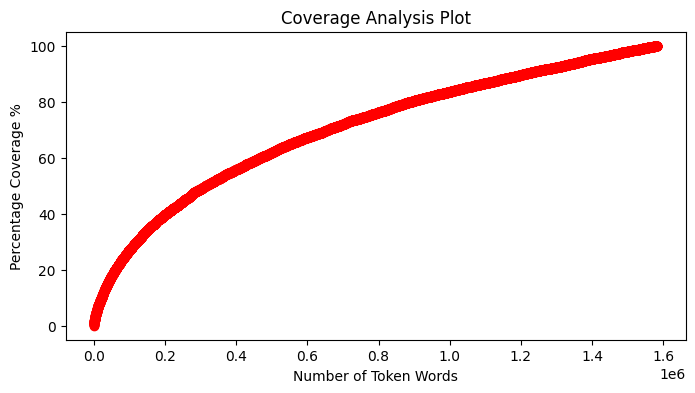

In [37]:
# Extract the unique words from the preprocessed documents:
words = [word for doc, _ in documents for word in doc]
uniq_words = set(words)
unique_words_count = len(uniq_words)

# Calculate coverage percentage for respective vocab sizes:
voc_size = range(100, len(words), 100)
perc = []

for i in voc_size:
    sub_set = set(words[:i])
    cov_per = (len(sub_set) / unique_words_count) * 100
    perc.append(cov_per)

# Visualize the coverage analysis
plt.figure(figsize=(8, 4))
plt.plot(voc_size, perc, marker='o', linestyle='--', color='r')
plt.title('Coverage Analysis Plot')
plt.xlabel('Number of Token Words')
plt.ylabel('Percentage Coverage %')
plt.show()

### Discussions

#### Coverage analysis
The coverage analysis provides valuable insights into how the preprocessing steps affect the coverage of unique words in the dataset. Here are the observations based on the analysis:

* How does the coverage change with the number of tokens considered? \
Initially, as the number of tokens considered increases, the coverage percentage also increases rapidly. This is because adding more tokens introduces new unique words, thereby increasing coverage. However, as the number of tokens continues to increase, the rate of increase in coverage slows down.

* At what point does the coverage seem to stabilize? \
The coverage seems to stabilize at a certain point, indicating that adding more tokens beyond this point has diminishing returns in terms of covering unique words. After reaching this stabilization point, further increasing the number of tokens has minimal impact on increasing coverage.

* Are there diminishing returns in terms of coverage as the number of tokens increases? \
There are indeed diminishing returns in terms of coverage as the number of tokens increases. Initially, adding more tokens leads to a significant increase in coverage. However, as the vocabulary size grows larger, the incremental increase in coverage becomes smaller, indicating diminishing returns.


#### Rationalization for Vocabulary Choice :
The choice of vocabulary size for modeling involves several considerations to strike a balance between informativeness and computational efficiency:

* The trade-off between a larger vocabulary (more words) and computational efficiency. \
A larger vocabulary (more words) increases the complexity of the model and computational requirements. On the other hand, a smaller vocabulary reduces the computational burden but may result in loss of important information. Therefore, choosing an optimal vocabulary size involves balancing computational efficiency with the need for informative features.

* The impact of rare or very common words on the model's generalization. \
Rare words may introduce noise into the model, while very common words may not provide much discriminatory power. Therefore, it's essential to consider the impact of rare and very common words on the model's generalization. Choosing an appropriate cutoff for including or excluding such words in the vocabulary can help improve model performance.

* The need to balance informativeness and model complexity. \
The vocabulary size directly impacts the model's complexity and its ability to generalize to unseen data. A vocabulary that is too small may result in underfitting, while a vocabulary that is too large may lead to overfitting. Therefore, it's crucial to strike a balance between informativeness and model complexity by choosing a vocabulary size that captures the essential information without introducing unnecessary complexity.

* Any specific considerations for the chosen algorithms (Naive Bayes, Logistic Regression, MLP) in terms of vocabulary size. \
Different algorithms may have different sensitivities to vocabulary size. For example, Naive Bayes classifiers rely on word frequencies and may benefit from a larger vocabulary to capture more nuanced patterns in the data. In contrast, logistic regression and MLP models may be more flexible in handling larger vocabularies but may also require more computational resources. Therefore, the choice of algorithms may influence the decision regarding the vocabulary size.


## 3. Algorithm Implementation (6 marks):

In [52]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [48]:
# split the cleaned data into training and testing sets of 80-20
X_train, X_test, y_train, y_test = train_test_split(clean_df.iloc[:,0], clean_df.iloc[:,1], test_size=0.2, random_state=42)
print(f"Shape of X_train: {X_train.shape} \nShape of X_test: {X_test.shape}")

Shape of X_train: (1600,) 
Shape of X_test: (400,)


### a. Naive Bayes:
- Implement a Multinomial Naive Bayes classifier.
- Train and test the model using both TF and TF-IDF as feature representations.

In [60]:
# Function to train and test Naive Bayes classifier using TF or TF-IDF
def naive_bayes_classification(X_train, y_train, X_test, feature_representation, **kwargs):
    # Extract features from text data
    if feature_representation == 'TF':
        vectorizer = CountVectorizer()
    elif feature_representation == 'TF-IDF':
        vectorizer = TfidfVectorizer()
    else:
        raise ValueError("Invalid feature representation. Choose 'TF' or 'TF-IDF'.")

    train_data = vectorizer.fit_transform(X_train)
    test_data = vectorizer.transform(X_test)
    
    # Train Naive Bayes classifier
    classifier = MultinomialNB()
    classifier.fit(train_data, y_train)
    
    # Test Naive Bayes classifier
    predictions = classifier.predict(test_data)
    
    return predictions

### b. Logistic Regression:
- Implement a Logistic Regression classifier.
- Train and test the model using both TF and TF-IDF.

In [61]:
# Function to train and test Logistic Regression classifier using TF or TF-IDF
def logistic_regression(X_train, y_train, X_test, feature_representation, **kwargs):
    # Extract features from text data
    if feature_representation == 'TF':
        vectorizer = CountVectorizer()
    elif feature_representation == 'TF-IDF':
        vectorizer = TfidfVectorizer()
    else:
        raise ValueError("Invalid feature representation. Choose 'TF' or 'TF-IDF'.")

    train_data = vectorizer.fit_transform(X_train)
    test_data = vectorizer.transform(X_test)
    
    # Train Logistic Regression classifier
    classifier = LogisticRegression()
    classifier.fit(train_data, y_train)
    
    # Test Logistic Regression classifier
    predictions = classifier.predict(test_data)
    
    return predictions

### c. Multilayer Perceptron (MLP): 
* Implement an MLP-based classifier.
* Explore different architectures (number of layers, neurons per layer). 
* Train and test the model using both TF and TF-IDF.

In [62]:
# Function to train and test Multilayer Perceptron classifier using TF or TF-IDF
def mlp_classifier(X_train, y_train, X_test, feature_representation, **kwargs):
    
    # Extract model parameters
    mlp_arch = kwargs.get("mlp_arch", (100,))
    max_iter = kwargs.get("max_iter", 500)

    # Extract features from text data
    if feature_representation == 'TF':
        vectorizer = CountVectorizer()
    elif feature_representation == 'TF-IDF':
        vectorizer = TfidfVectorizer()
    else:
        raise ValueError("Invalid feature representation. Choose 'TF' or 'TF-IDF'.")

    train_data = vectorizer.fit_transform(X_train)
    test_data = vectorizer.transform(X_test)
    
    # Train MLP classifier
    classifier = MLPClassifier(hidden_layer_sizes=mlp_arch, max_iter=max_iter)
    classifier.fit(train_data, y_train)
    
    # Test MLP classifier
    predictions = classifier.predict(test_data)
    
    return predictions

### 4. Training and Evaluation (4 marks):
* Train each algorithm on the training set.
* Evaluate the performance of each algorithm on the testing set using accuracy, TPR, FPR as the primary metrics.
* Compare the impact of using TF and TF-IDF on each algorithm's performance.

In [89]:
def calculate_tpr_fpr(confusion_matrix):
    TN, FP, FN, TP = confusion_matrix.ravel()
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    return TPR, FPR

def train_evaluate(model_name, classification_function, X_train, y_train, X_test, y_test, results_df, **kwargs):
    # Train and test using TF representation
    predictions_tf = classification_function(X_train, y_train, X_test, 'TF', **kwargs)
    accuracy_tf = accuracy_score(y_test, predictions_tf)
    confusion_matrix_tf = confusion_matrix(y_test, predictions_tf)
    TPR_tf, FPR_tf = calculate_tpr_fpr(confusion_matrix_tf)
    df_tf = pd.DataFrame({
        'Model': [model_name + '_TF'],
        'Accuracy': [accuracy_tf],
        'TPR': [TPR_tf],
        'FPR': [FPR_tf]
    })

    # Train and test using TF-IDF representation
    predictions_tfidf = classification_function(X_train, y_train, X_test, 'TF-IDF', **kwargs)
    accuracy_tfidf = accuracy_score(y_test, predictions_tfidf)
    confusion_matrix_tfidf = confusion_matrix(y_test, predictions_tfidf)
    TPR_tfidf, FPR_tfidf = calculate_tpr_fpr(confusion_matrix_tfidf)
    df_tfidf = pd.DataFrame({
        'Model': [model_name + '_TF-IDF'],
        'Accuracy': [accuracy_tfidf],
        'TPR': [TPR_tfidf],
        'FPR': [FPR_tfidf]
    })

    # Concatenate dataframes and append to results_df
    results_df = pd.concat([results_df, df_tf, df_tfidf], ignore_index=True)
    
    # Print performance metrics
    print(f"Performance metrics for {model_name} using TF representation:")
    print("Accuracy:", accuracy_tf)
    print("TPR:", TPR_tf)
    print("FPR:", FPR_tf)

    print(f"\nPerformance metrics for {model_name} using TF-IDF representation:")
    print("Accuracy:", accuracy_tfidf)
    print("TPR:", TPR_tfidf)
    print("FPR:", FPR_tfidf)

    return results_df

In [92]:
results_df = pd.DataFrame(columns=["Model", "Accuracy", "TPR", "FPR"])
results_df = train_evaluate('NaiveBayes', naive_bayes_classification, X_train, y_train, X_test, y_test, results_df)

Performance metrics for NaiveBayes using TF representation:
Accuracy: 0.765
TPR: 0.7582938388625592
FPR: 0.2275132275132275

Performance metrics for NaiveBayes using TF-IDF representation:
Accuracy: 0.75
TPR: 0.6729857819905213
FPR: 0.164021164021164


In [93]:
results_df = train_evaluate('LogisticReg', logistic_regression, X_train, y_train, X_test, y_test, results_df)

Performance metrics for LogisticReg using TF representation:
Accuracy: 0.81
TPR: 0.7962085308056872
FPR: 0.1746031746031746

Performance metrics for LogisticReg using TF-IDF representation:
Accuracy: 0.8175
TPR: 0.8199052132701422
FPR: 0.18518518518518517


In [94]:
results_df = train_evaluate("MLP_1", mlp_classifier, X_train, y_train, X_test, y_test, results_df, kwargs={"mlp_arch": (100,), "max_iter": 500})

Performance metrics for MLP_1 using TF representation:
Accuracy: 0.8175
TPR: 0.8056872037914692
FPR: 0.1693121693121693

Performance metrics for MLP_1 using TF-IDF representation:
Accuracy: 0.8
TPR: 0.8056872037914692
FPR: 0.20634920634920634


In [95]:
results_df = train_evaluate("MLP_2", mlp_classifier, X_train, y_train, X_test, y_test, results_df, kwargs={"mlp_arch": (50, 20), "max_iter": 500})

Performance metrics for MLP_2 using TF representation:
Accuracy: 0.8125
TPR: 0.8104265402843602
FPR: 0.18518518518518517

Performance metrics for MLP_2 using TF-IDF representation:
Accuracy: 0.7875
TPR: 0.8009478672985783
FPR: 0.2275132275132275


In [96]:
results_df = train_evaluate("MLP_3", mlp_classifier, X_train, y_train, X_test, y_test, results_df, kwargs={"mlp_arch": (100, 50, 20), "max_iter": 500})

Performance metrics for MLP_3 using TF representation:
Accuracy: 0.8175
TPR: 0.8151658767772512
FPR: 0.17989417989417988

Performance metrics for MLP_3 using TF-IDF representation:
Accuracy: 0.7975
TPR: 0.7962085308056872
FPR: 0.20105820105820105


In [97]:
results_df

,Model,Accuracy,TPR,FPR
0,NaiveBayes_TF,0.7650,0.758294,0.227513
1,NaiveBayes_TF-IDF,0.7500,0.672986,0.164021
2,LogisticReg_TF,0.8100,0.796209,0.174603
3,LogisticReg_TF-IDF,0.8175,0.819905,0.185185
4,MLP_1_TF,0.8175,0.805687,0.169312
5,MLP_1_TF-IDF,0.8000,0.805687,0.206349
6,MLP_2_TF,0.8125,0.810427,0.185185
7,MLP_2_TF-IDF,0.7875,0.800948,0.227513
8,MLP_3_TF,0.8175,0.815166,0.179894
9,MLP_3_TF-IDF,0.7975,0.796209,0.201058


### 5. Visualization and Analysis (2 marks):
* Visualize the performance metrics (e.g., accuracy) for each algorithm using appropriate plots (e.g., bar chart).
* Discuss any observed trends or differences in performance.


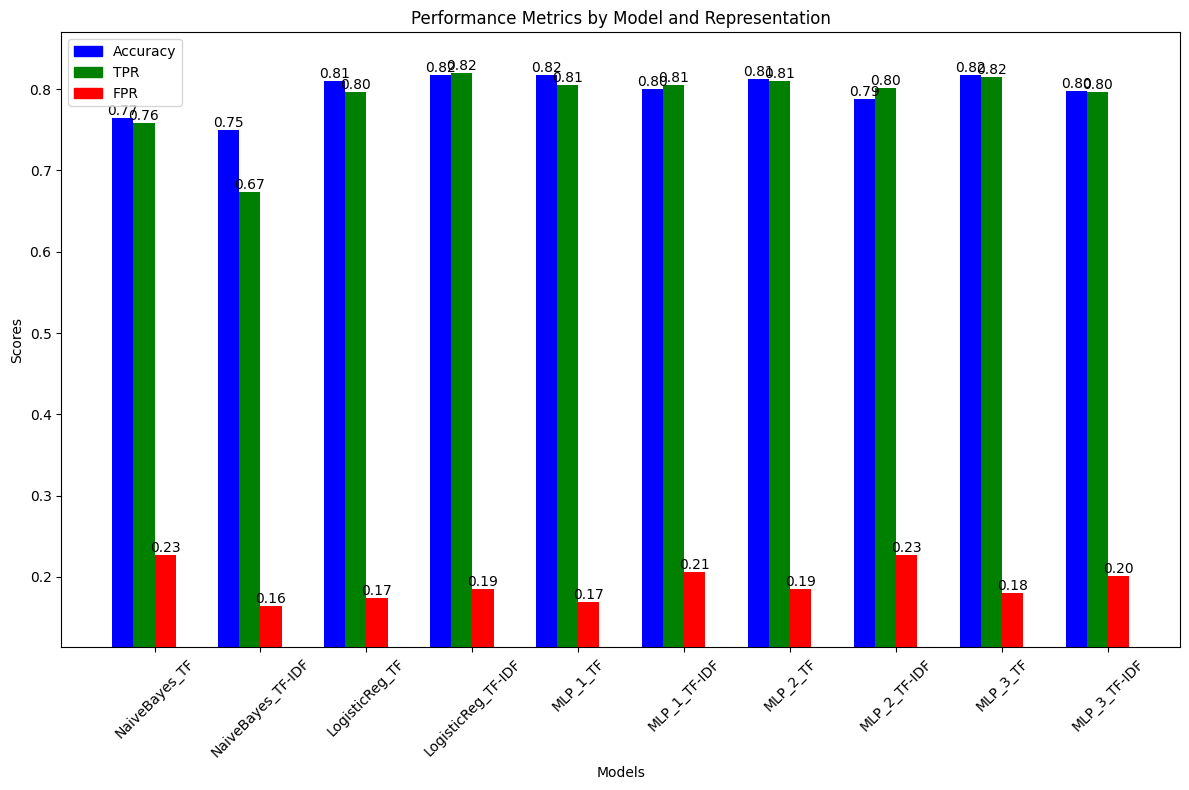

In [113]:
# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Set color map
colors = {'Accuracy': 'b', 'TPR': 'g', 'FPR': 'r'}

# Get unique models
models = results_df['Model'].unique()

y_min = float('inf')
y_max = float('-inf')

# Set bar dimensions
bar_width = 0.2
num_metrics = 3
bar_positions = np.arange(len(models))

for i, model in enumerate(models):
    model_df = results_df[results_df['Model'] == model]
    metric_vals = model_df[['Accuracy', 'TPR', 'FPR']].values.flatten()
    
    # Plot bars for each metric
    for j in range(num_metrics):
        # Update y-axis limits
        y_min = min(y_min, min(metric_vals[j::num_metrics]))
        y_max = max(y_max, max(metric_vals[j::num_metrics]))

# Set y-axis limits based on min and max values
ax.set_ylim([y_min - 0.05, y_max + 0.05])

# Plot bars for each metric
for j, metric in enumerate(['Accuracy', 'TPR', 'FPR']):
    values = results_df[metric].values
    ax.bar(bar_positions + j * bar_width - (num_metrics * bar_width) / 2, values, width=bar_width, color=colors[metric], label=metric)

# Add values on bar tips
for i, model in enumerate(models):
    model_df = results_df[results_df['Model'] == model]
    metric_vals = model_df[['Accuracy', 'TPR', 'FPR']].values.flatten()
    
    # Add values on bar tips
    for j, value in enumerate(metric_vals):
        ax.text(bar_positions[i] + j * bar_width - bar_width*1.5, value, f'{value:.2f}', ha='center', va='bottom')


# Set labels and title
ax.set_xticks(bar_positions)
ax.set_xticklabels(models, rotation=45)
ax.set_ylabel('Scores')
ax.set_xlabel('Models')
ax.set_title('Performance Metrics by Model and Representation')

# # Add legend
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles, labels, loc='lower right')
legend_handles = [plt.Rectangle((0,0),1,1, color=color) for metric, color in colors.items()]
legend_labels = list(colors.keys())
ax.legend(legend_handles, legend_labels, loc='best')

# Show plot
plt.tight_layout()
plt.show()


#### Observed Trends and Differences in Performance:

* **Accuracy Trends** :
   - Logistic Regression consistently performs well, with both TF and TF-IDF representations yielding high accuracies.
   - Naive Bayes also performs decently, but with slightly lower accuracies compared to Logistic Regression.
   - MLP shows varying performance across different configurations, but generally achieves competitive accuracies. 

* **True Positive Rate (TPR)** :
  - Logistic Regression consistently exhibits high TPR values, indicating its effectiveness in correctly identifying positive sentiment.
  - MLP also shows competitive TPR values, especially for certain configurations.
  - Naive Bayes tends to have lower TPR values compared to the other algorithms, especially noticeable in the TF-IDF representation.


* **False Positive Rate (FPR)** :
  - Naive Bayes exhibits higher FPR values across both TF and TF-IDF representations, indicating a tendency to incorrectly classify negative instances as positive.
  - Logistic Regression and MLP generally have lower FPR values, suggesting better precision in distinguishing negative instances.


### 6. Discussion (3 marks):
* Compare and analyze the results obtained by the three algorithms.
* Discuss the impact of using TF vs. TF-IDF on classification performance.
* Provide insights into the strengths and limitations of each algorithm in the context of sentiment analysis.

#### Comparison and Analysis of Algorithm Results:

1. **Naive Bayes**:
   - Performs reasonably well but tends to have lower TPR and higher FPR compared to Logistic Regression and MLP.
   - Simple and efficient, making it suitable for large datasets.
   - However, it assumes independence among features, which may not hold true for natural language, impacting performance.

2. **Logistic Regression**:
   - Shows consistently high performance across both TF and TF-IDF representations.
   - Effective in modeling linear relationships between features and target variable.
   - May suffer from overfitting if the feature space is large or if there are too many irrelevant features.

3. **Multilayer Perceptron (MLP)**:
   - Exhibits competitive performance, especially with certain configurations.
   - Can capture complex non-linear relationships in the data, potentially improving performance.
   - Requires careful tuning of hyperparameters and may be computationally expensive, especially with large datasets.

#### Impact of TF vs. TF-IDF on Classification Performance:

* **TF Representation**:
  - Generally yields lower accuracies compared to TF-IDF, especially for Naive Bayes.
  - May be susceptible to the influence of frequent but less informative words (e.g., stopwords), affecting model performance.

* **TF-IDF Representation**:

  - Tends to improve classification performance, particularly for algorithms like Naive Bayes.
  - Accounts for the importance of words in the corpus by weighing down frequent but less discriminative terms.
  - Offers better generalization by reducing the impact of common words that may not contribute significantly to sentiment classification.


#### Strengths and Limitations of Each Algorithm:

* **Naive Bayes**:

- *Strengths*: Simple, fast, and easy to implement. Handles large datasets well.
- *Limitations*: Relies on the assumption of feature independence, which may not hold true for text data. Limited ability to capture complex relationships.

* **Logistic Regression**:

- *Strengths*: Robust, interpretable, and performs well with linearly separable data.
- *Limitations*: Assumes linear relationship between features and target variable, may not capture non-linear patterns effectively without feature engineering.

* **Multilayer Perceptron (MLP)**:

- *Strengths*: Can capture complex non-linear relationships, making it suitable for tasks with intricate patterns.
- *Limitations*: Requires careful tuning of hyperparameters, susceptible to overfitting, and computationally expensive, especially with large datasets.
